In [ ]:
%%capture
!pip install pandas==1.2.4
!pip install pandas-profiling==2.7.1

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.0/spark-2.4.0-bin-hadoop2.7.tgz
!tar -xvf spark-2.4.0-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.0-bin-hadoop2.7"
import findspark
findspark.init()

spark-2.4.0-bin-hadoop2.7/
spark-2.4.0-bin-hadoop2.7/python/
spark-2.4.0-bin-hadoop2.7/python/setup.cfg
spark-2.4.0-bin-hadoop2.7/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/resultiterable.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/
spark-2.4.0-bin-hadoop2.7/python/pyspark/python/pyspark/shell.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/heapq3.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/join.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/version.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/rdd.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/java_gateway.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/find_spark_home.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/_globals.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/worker.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/accumulators.py
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/
spark-2.4.0-bin-hadoop2.7/python/pyspark/mllib/feature.py
spark-2.4.0-bin-hadoop2.7/python/pyspark

#Bước 1: Data understanding

In [ ]:
# import libraries
from pyspark import SparkContext
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import scipy
from pyspark.sql.types import *
import pandas_profiling as pp

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
%matplotlib inline

In [ ]:
sc = SparkContext()
spark = SparkSession.builder.appName("women-closing").getOrCreate()

In [ ]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [ ]:
#đọc dữ liệu:
f = pd.read_excel('Womens_Clothing_E_Commerce_Reviews.xlsx', sheet_name='Reviews', index_col=0)
f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23481 entries, 0 to 23480
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23481 non-null  int64 
 1   Age                      23481 non-null  int64 
 2   Title                    19671 non-null  object
 3   Review Text              22636 non-null  object
 4   Rating                   23481 non-null  int64 
 5   Recommended IND          23481 non-null  int64 
 6   Positive Feedback Count  23481 non-null  int64 
 7   Division Name            23467 non-null  object
 8   Department Name          23467 non-null  object
 9   Class Name               23467 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [ ]:
f.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


#Bước 2: Data preparation

In [ ]:
pp.ProfileReport(f)

Summarize dataset:   0%|          | 0/22 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
f = f.dropna(subset=['Review Text'], axis=0)
f = f.reset_index(drop=True)

In [ ]:
data_2 = pd.read_excel('Womens_Clothing_E_Commerce_Reviews.xlsx',sheet_name='new_reviews',index_col=0)

In [ ]:
# Convert pandas to pyspark DataFrame
from pyspark.sql.types import *
df_schema = StructType([StructField("Clothing ID",IntegerType(), True),StructField("Age", IntegerType(), True),
                        StructField("Title", StringType(), True),StructField("Review Text", StringType(), True),
                        StructField("Rating", IntegerType(), True),StructField("Recommended IND", IntegerType(), True),
                        StructField("Positive Feedback Count", IntegerType(), True),StructField("Division Name", StringType(), True),
                        StructField("Department Name", StringType(),True),StructField("Class Name", StringType(), True)])

In [ ]:
# Convert pandas to pyspark DataFrame
df_schema_1 = StructType([StructField("Clothing ID",IntegerType(), True),StructField("Age", IntegerType(), True),
                        StructField("Title", StringType(), True),StructField("Review Text", StringType(), True),
                        StructField("Recommended IND", IntegerType(), True),
                        StructField("Positive Feedback Count", IntegerType(), True),StructField("Division Name", StringType(), True),
                        StructField("Department Name", StringType(),True),StructField("Class Name", StringType(), True)])

In [ ]:
#tạo ra dataframe spark bằng dataframe pandas:
df = spark.createDataFrame(f, schema=df_schema) 

In [ ]:
df_test = spark.createDataFrame(data_2,schema=df_schema_1)

In [ ]:
df = df.select('Age','Review Text','Rating','Recommended IND','Positive Feedback Count')

In [ ]:
df.count()

22636

In [ ]:
df.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- Review Text: string (nullable = true)
 |-- Rating: integer (nullable = true)
 |-- Recommended IND: integer (nullable = true)
 |-- Positive Feedback Count: integer (nullable = true)



In [ ]:
df.show(5)

+---+--------------------+------+---------------+-----------------------+
|Age|         Review Text|Rating|Recommended IND|Positive Feedback Count|
+---+--------------------+------+---------------+-----------------------+
| 33|Absolutely wonder...|     4|              1|                      0|
| 34|Love this dress! ...|     5|              1|                      4|
| 60|I had such high h...|     3|              0|                      0|
| 50|I love, love, lov...|     5|              1|                      0|
| 47|This shirt is ver...|     5|              1|                      6|
+---+--------------------+------+---------------+-----------------------+
only showing top 5 rows



In [ ]:
df.describe().show()

+-------+------------------+--------------------+------------------+-------------------+-----------------------+
|summary|               Age|         Review Text|            Rating|    Recommended IND|Positive Feedback Count|
+-------+------------------+--------------------+------------------+-------------------+-----------------------+
|  count|             22636|               22636|             22636|              22636|                  22636|
|   mean|  43.2802173528892|                null| 4.183822230075985| 0.8189609471638098|     2.6300141367732817|
| stddev|12.326730776755717|                null|1.1155489931088793|0.38505904013595876|      5.786116272940633|
|    min|                18|"does this sweate...|                 1|                  0|                      0|
|    max|                99|Yummy, soft mater...|                 5|                  1|                    122|
+-------+------------------+--------------------+------------------+-------------------+--------

In [ ]:
from pyspark.sql.functions import *

In [ ]:
#kiểm tra dữ liệu có NaN không --> không có NaN
df.select([count(when(isnan(x),x)).alias(x) for x in df.columns]).toPandas().T

,0
Age,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0


In [ ]:
# Kiểm tra dữ liệu null => không có dữ liệu null
df.select([count(when(col(x).isNull(),x)).alias(x) for x in df.columns]).toPandas().T

,0
Age,0
Review Text,0
Rating,0
Recommended IND,0
Positive Feedback Count,0


In [ ]:
# Kiểm tra dữ liệu trùng lắp => không có dữ liệu trùng lắp
df.count()-df.distinct().count()

3

In [ ]:
# Xóa dữ liệu trùng lắp
df = df.dropDuplicates()

#3. Phân tích các biến

**Phân tích đơn biến**

In [ ]:
#chuyển spark dataframe về pandas dataframe

In [ ]:
df_pd = df.toPandas()

In [ ]:
df_pd.head()

,Age,Review Text,Rating,Recommended IND,Positive Feedback Count
0,34,"I'm 5""5' and 125 lbs. i ordered the s petite t...",5,1,0
1,31,"Loved the material, but i didnt really look at...",3,0,0
2,43,"Dang, i got a small and was still swimming in ...",3,0,0
3,66,My daughter and i both purchased this vest at ...,5,1,6
4,27,When i ordered this little jacket i knew i wou...,5,1,0


- Các biến input liên tục: Age, Positive Feedback Count
- Biến phân loại: Recommended IND, Rating (output)

###Các biến liên tục

In [ ]:
import scipy

skew =  0.5155984582724872 (> 0): Phan phoi lech phai
kurtosis =  -0.12977211857183368 (< 0): Phan phoi khong nhon bang phan phoi chuan
Q1 =  34.0 , Q3 =  52.0 , IQR =  18.0
var =  151.95349198720194 , std =  12.326941712655332


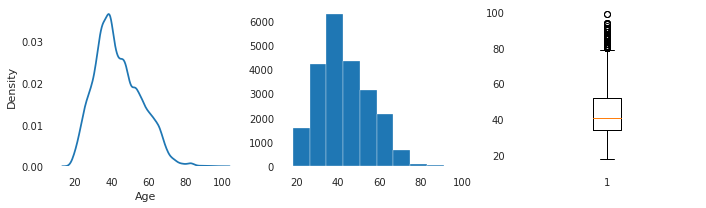

so outlier (UPPER) =  108
so outlier (LOWER) =  0
% outlier =  0.4771793399019131 %


In [ ]:
#Age
Q1_Age= np.percentile(df_pd.Age, 25)
Q3_Age= np.percentile(df_pd.Age, 75) 
iqr_Age= scipy.stats.iqr(df_pd.Age) 
var = df_pd.Age.var()
std = df_pd.Age.std() 
skew = df_pd.Age.skew() 
kurtosis = df_pd.Age.kurtosis() 
#---------------------------------------------------
if skew > 0:
    print('skew = ', skew, '(> 0): Phan phoi lech phai')
elif skew == 0:
    print('skew = 0: Phan phoi khong lech so voi phan phoi chuan') 
else:
    print('skew = ', skew,'(< 0): Phan phoi lech trai')

if kurtosis > 0:
    print('kurtosis = ', kurtosis, '(> 0): Phan phoi nhon hon phan phoi chuan')
elif kurtosis == 0:
    print('kurtosis = 0: Phan phoi co do nhon bang phan phoi chuan')
else:
    print('kurtosis = ', kurtosis, '(< 0): Phan phoi khong nhon bang phan phoi chuan')

print('Q1 = ', Q1_Age, ', Q3 = ', Q3_Age, ', IQR = ', iqr_Age)
print('var = ', var, ', std = ', std)
#Visualization
plt.figure(figsize=(10, 3), tight_layout=True)
plt.subplot(1, 3, 1) 
sns.kdeplot(df_pd['Age'])
plt.subplot(1, 3, 2)
plt.hist(df_pd['Age']) 
plt.subplot(1, 3, 3)
plt.boxplot(df_pd['Age']) 
plt.show() 
#------------------------------------
#So outlier 
n_o_upper = df_pd[df_pd['Age'] > (Q3_Age+ 1.5*iqr_Age)].shape[0] 
n_o_lower = df_pd[df_pd['Age'] < (Q1_Age- 1.5*iqr_Age)].shape[0]  
print('so outlier (UPPER) = ', n_o_upper) 
print('so outlier (LOWER) = ', n_o_lower) 
print('% outlier = ', (n_o_upper + n_o_lower) / df_pd.shape[0] * 100 , '%' )


Nhận xét: khách hàng có độ tuổi chủ yếu từ 30 - 50 tuổi

skew =  6.381734506081892 (> 0): Phan phoi lech phai
kurtosis =  69.6738251488181 (> 0): Phan phoi nhon hon phan phoi chuan
Q1 =  0.0 , Q3 =  3.0 , IQR =  3.0
var =  33.48266236841049 , std =  5.786420514308521


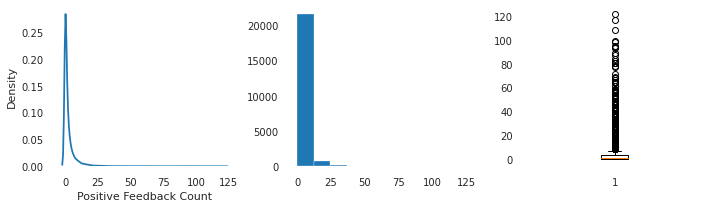

so outlier (UPPER) =  2145
so outlier (LOWER) =  0
% outlier =  9.477311889718552 %


In [ ]:
#Positive Feedback Count
Q1_Positive= np.percentile(df_pd['Positive Feedback Count'], 25)
Q3_Positive= np.percentile(df_pd['Positive Feedback Count'], 75) 
iqr_Positive= scipy.stats.iqr(df_pd['Positive Feedback Count']) 
var = df_pd['Positive Feedback Count'].var()
std = df_pd['Positive Feedback Count'].std() 
skew = df_pd['Positive Feedback Count'].skew() 
kurtosis = df_pd['Positive Feedback Count'].kurtosis() 
#---------------------------------------------------
if skew > 0:
    print('skew = ', skew, '(> 0): Phan phoi lech phai')
elif skew == 0:
    print('skew = 0: Phan phoi khong lech so voi phan phoi chuan') 
else:
    print('skew = ', skew,'(< 0): Phan phoi lech trai')

if kurtosis > 0:
    print('kurtosis = ', kurtosis, '(> 0): Phan phoi nhon hon phan phoi chuan')
elif kurtosis == 0:
    print('kurtosis = 0: Phan phoi co do nhon bang phan phoi chuan')
else:
    print('kurtosis = ', kurtosis, '(< 0): Phan phoi khong nhon bang phan phoi chuan')

print('Q1 = ', Q1_Positive, ', Q3 = ', Q3_Positive, ', IQR = ', iqr_Positive)
print('var = ', var, ', std = ', std)
#Visualization
plt.figure(figsize=(10, 3), tight_layout=True)
plt.subplot(1, 3, 1) 
sns.kdeplot(df_pd['Positive Feedback Count'])
plt.subplot(1, 3, 2)
plt.hist(df_pd['Positive Feedback Count']) 
plt.subplot(1, 3, 3)
plt.boxplot(df_pd['Positive Feedback Count']) 
plt.show() 
#------------------------------------
#So outlier 
n_o_upper = df_pd[df_pd['Positive Feedback Count'] > (Q3_Positive+ 1.5*iqr_Positive)].shape[0] 
n_o_lower = df_pd[df_pd['Positive Feedback Count'] < (Q1_Positive- 1.5*iqr_Positive)].shape[0]  
print('so outlier (UPPER) = ', n_o_upper) 
print('so outlier (LOWER) = ', n_o_lower) 
print('% outlier = ', (n_o_upper + n_o_lower) / df_pd.shape[0] * 100 , '%' )


Nhận xét: Possitive Feedback Count có phân phối lệch phải.

###Biến phân loại

5    12536
4     4907
3     2822
2     1548
1      820
Name: Rating, dtype: int64


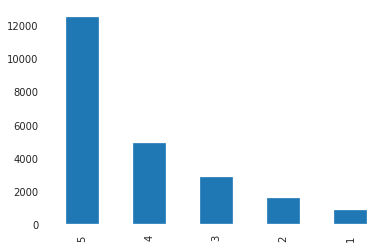

In [ ]:
#Rating
print(df_pd['Rating'].value_counts()   ) 
df_pd['Rating'].value_counts().plot.bar() 

Nhận xét: khách hàng có xu hướng cho rating cao (5 điểm và 4 điểm).

1    18535
0     4098
Name: Recommended IND, dtype: int64


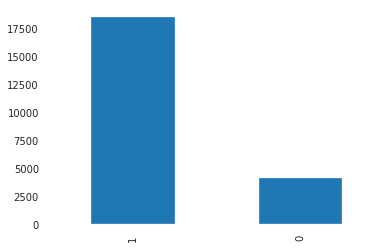

In [ ]:
#Recommended IND
print(df_pd['Recommended IND'].value_counts()   ) 
df_pd['Recommended IND'].value_counts().plot.bar() 

Nhận xét: khách hàng có xu hướng recommend sản phẩm (1). Số ít khách hàng không recommend sản phẩm (0)

###Phân tích giữa 2 biến liên tục

In [ ]:
df_pd[['Age', 'Positive Feedback Count']].corr()

,Age,Positive Feedback Count
Age,1.000000,0.040772
Positive Feedback Count,0.040772,1.000000


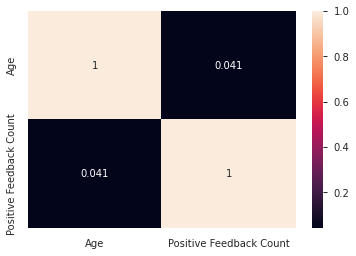

In [ ]:
plt.subplots(figsize=(6, 4))
ax = sns.heatmap(df_pd[['Age', 'Positive Feedback Count']].corr(),annot=True)
plt.show()

Nhận xét: giữa 2 biến Age và Positive Feedback Count có quan hệ tuyến tính yếu

###Giữa các biến phân loại

Kiểm định chi_2:
- H0: 2 biến độc lập
- p <= 0.05 --> bác bỏ H0 --> 2 biến phụ thuộc
- p > 0.05 --> chấp nhận H0: 2 biến độc lập

In [ ]:
from scipy.stats import chi2_contingency
from scipy.stats import chi2
import statsmodels.api as sm  
from statsmodels.formula.api import ols 
from statsmodels.stats.multicomp import pairwise_tukeyhsd 

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Gỉa thiết H0: 2 biến độc lập (independent)
table = pd.crosstab(df_pd['Rating'], df_pd['Recommended IND']) 
#chi-squared test
alpha = 0.05
stat, p, dof, expected = chi2_contingency(table)
print('p = ', p, '\t', 'alpha = ', alpha)  

if p <= alpha:
    print('Reject H0: 2 bien khong doc lap (Dependent)')
else:
    print('Accept H0: 2 bien doc lap (Independent)') 

p =  0.0 	 alpha =  0.05
Reject H0: 2 bien khong doc lap (Dependent)


Nhận xét: Recommended IND có ảnh hưởng đến rating

###Giữa biến liên tục và phân loại

Giả định ANOVA:
- H0: quan hệ giữa 2 biến không có ý nghĩa thống kê (không có sự khác biệt giữa mean giữa các biến quan sát)
- P <= 0.05 --> bác bỏ H0: quan hệ giữa 2 biến có ý nghĩa thống kê
- P > 0.05 --> chấp nhận H0: quan hệ giữa 2 biến không có ý nghĩa thống kê

In [ ]:
#quan hệ Recommended IND, Rating và Age có ý nghĩa thống kê không?

In [ ]:
x = df_pd['Age']
y = df_pd['Recommended IND']
z = df_pd['Rating']
model= ols('x ~ C(y)+C(z)',data=df_pd).fit()
anova = sm.stats.anova_lm(model,typ=2)
print(anova,'\n')

                sum_sq       df         F    PR(>F)
C(y)      1.409684e+03      1.0  9.297514  0.002297
C(z)      4.304500e+03      4.0  7.097537  0.000010
Residual  3.430694e+06  22627.0       NaN       NaN 



Nhận xét: từ P-value thu được từ ANOVA:
- Quan hệ giữa Age và Recommended IND có ý  nghĩa thống kê
- Quan hệ giữa Age và Rating có ý nghĩa thống kê

In [ ]:
x = df_pd['Positive Feedback Count']
y = df_pd['Recommended IND']
z = df_pd['Rating']
model= ols('x ~ C(y)+C(z)',data=df_pd).fit()
anova = sm.stats.anova_lm(model,typ=2)
print(anova,'\n')

                 sum_sq       df          F    PR(>F)
C(y)         382.961455      1.0  11.488256  0.000702
C(z)         241.539234      4.0   1.811452  0.123495
Residual  754271.922582  22627.0        NaN       NaN 



Nhận xét: từ P-value thu được từ ANOVA:
- Quan hệ giữa Positive Feedback Count và Recommended IND có ý  nghĩa thống kê
- Quan hệ giữa Positive Feedback Count và Rating **KHÔNG** có ý nghĩa thống kê (Rating không phụ thuộc vào Positive Feedback Count)
==> loại biến Positive Feedback Count do không có quan hệ với output (Rating)

#Feature Transformation

In [ ]:
#chọn ra các cột cần cho bài toán (spark dataframe)
df1 = df.select('Age', 'Review Text', 'Rating', 'Recommended IND')
df1.show(5)

+---+--------------------+------+---------------+
|Age|         Review Text|Rating|Recommended IND|
+---+--------------------+------+---------------+
| 34|I'm 5"5' and 125 ...|     5|              1|
| 31|Loved the materia...|     3|              0|
| 43|Dang, i got a sma...|     3|              0|
| 66|My daughter and i...|     5|              1|
| 27|When i ordered th...|     5|              1|
+---+--------------------+------+---------------+
only showing top 5 rows



###Loại bỏ các từ không cần thiết trong Review Text như link, số, emoji, ...

In [ ]:
#loại bỏ link ra khỏi Review Text
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), 'https?://\S+|www\.\S+', ''))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), 'https?://\S+|www\.\S+', ''))

#loại html
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), '<.*?>', ''))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), '<.*?>', ''))

In [ ]:
#loại bỏ @word (chữ bắt đầu bằng @)
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), '\@\w+', ''))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), '\@\w+', ''))
#loại bỏ #word (chữ bắt đầu bằng #)
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), '\#\w+', ''))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), '\#\w+', ''))

In [ ]:
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "won\'t", " will not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "won\'t've", " will not have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "can\'t", " can not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "don\'t", " do not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "can\'t've", " can not have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "ma\'am", " madam"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "let\'s", " let us"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "ain\'t", " am not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "shan\'t", " shall not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "sha\n't", " shall not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "o\'clock", " of the clock"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "y\'all", " you all"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "n\'t", " not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "n\'t've", " not have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'re", " are"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'s", " is"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'d", " would"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'d've", " would have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ll", " will"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ll've", " will have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'t", " not"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ve", " have"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'m", " am"))
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "\'re", " are"))

In [ ]:
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "won\'t", " will not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "won\'t've", " will not have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "can\'t", " can not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "don\'t", " do not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "can\'t've", " can not have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "ma\'am", " madam"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "let\'s", " let us"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "ain\'t", " am not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "shan\'t", " shall not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "sha\n't", " shall not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "o\'clock", " of the clock"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "y\'all", " you all"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "n\'t", " not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "n\'t've", " not have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'re", " are"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'s", " is"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'d", " would"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'d've", " would have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ll", " will"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ll've", " will have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'t", " not"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'ve", " have"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'m", " am"))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "\'re", " are"))



In [ ]:
#loại bỏ emoji
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", ''))



In [ ]:
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), "["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", ''))

In [ ]:
#loại bỏ những ký tự không phải chữ (từ a-zA-Z, không tính số) --> thay bằng space
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), '[^a-zA-Z]',' '))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), '[^a-zA-Z]',' '))
#loại bỏ những từ chỉ có 1 ký tự (không có ý nghĩa nhiều)
df1 = df1.withColumn("Review Text", regexp_replace(col("Review Text"), ' \w{1} |^\w{1} | \w{1}$',' '))
df_test = df_test.withColumn("Review Text", regexp_replace(col("Review Text"), ' \w{1} |^\w{1} | \w{1}$',' '))

In [ ]:
#chưa áp dụng loại bỏ từ
df.select('Review Text').show(5, truncate = False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review Text                                                                                                                                                                                                                                                                                                                                                             |
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#đã áp dụng loại bỏ từ
df1.select('Review Text').show(5, truncate = False)

+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review Text                                                                                                                                                                                                                                                                                                                                             |
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
#tạo ra cột length
df1 = df1.withColumn('length', length(df1['Review Text']))

In [ ]:
#tạo ra cột length
df_test = df_test.withColumn('length', length(df_test['Review Text']))

In [ ]:
from pyspark.sql.functions import lit
#them cột Rating = 0 vào test data
df_test = df_test.withColumn('Rating', lit(0))

In [ ]:
df1.show(5)

+---+--------------------+------+---------------+------+
|Age|         Review Text|Rating|Recommended IND|length|
+---+--------------------+------+---------------+------+
| 34| am      and     ...|     5|              1|   344|
| 31|Loved the materia...|     3|              0|   328|
| 43|Dang  got small a...|     3|              0|   259|
| 66|My daughter and b...|     5|              1|   225|
| 27|When ordered this...|     5|              1|   295|
+---+--------------------+------+---------------+------+
only showing top 5 rows



#Bước 3 & 4: Modeling and Evaluation/ Analyze & Report

In [ ]:
from pyspark.ml.feature import *

In [ ]:
tokenizer = Tokenizer(inputCol='Review Text', outputCol='ReviewText_text')
stopremove = StopWordsRemover(inputCol='ReviewText_text', outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens', outputCol='c_vec', vocabSize=100) #lấy 100 từ quan trọng
idf = IDF(inputCol='c_vec', outputCol='tf_idf')

In [ ]:
clean_up = VectorAssembler(inputCols=['tf_idf', 'Age','length', 'Recommended IND'],
                           outputCol='features')

###Pipeline

In [ ]:
from pyspark.ml import Pipeline 

In [ ]:
data_prep_pipe = Pipeline(stages=[
        tokenizer,
        stopremove,
        count_vec,
        idf,
        clean_up
])

In [ ]:
#fit và transform data vào pipeline
cleaner = data_prep_pipe.fit(df1)
clean_data = cleaner.transform(df1)

In [ ]:
#chọn cột Rating làm output, cột features làm input:
clean_data = clean_data.select(['Rating', 'features'])
clean_data.show(5)

+------+--------------------+
|Rating|            features|
+------+--------------------+
|     5|(103,[0,1,2,5,7,9...|
|     3|(103,[0,1,5,6,12,...|
|     3|(103,[0,9,10,18,2...|
|     5|(103,[0,18,33,49,...|
|     5|(103,[0,2,6,14,15...|
+------+--------------------+
only showing top 5 rows



###Chia dữ liệu train/ test

In [ ]:
training, testing = clean_data.randomSplit([0.7, 0.3])

In [ ]:
training.groupBy('Rating').count().show()

+------+-----+
|Rating|count|
+------+-----+
|     1|  596|
|     3| 1991|
|     5| 8671|
|     4| 3350|
|     2| 1114|
+------+-----+



In [ ]:
testing.groupBy('Rating').count().show()

+------+-----+
|Rating|count|
+------+-----+
|     1|  224|
|     3|  831|
|     5| 3865|
|     4| 1557|
|     2|  434|
+------+-----+



#Chọn lựa Model 

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression
from pyspark.ml.classification import GBTClassifier, RandomForestClassifier, NaiveBayes

In [ ]:
lrc1 = LogisticRegression(labelCol='Rating',featuresCol='features')
nbc1 = NaiveBayes(labelCol='Rating',featuresCol='features')
rfc1 = RandomForestClassifier(labelCol='Rating',featuresCol='features')
dtc1 = DecisionTreeClassifier(labelCol='Rating',featuresCol='features')

In [ ]:
lrc_model1 = lrc1.fit(training)
nbc_model1 = nbc1.fit(training)
rfc_model1 = rfc1.fit(training)
dtc_model1 = dtc1.fit(training)

In [ ]:
#Dự đoán kết quả trên test data:
lrc_predictions1 = lrc_model1.transform(testing)
nbc_predictions1 = nbc_model1.transform(testing)
rfc_predictions1 = rfc_model1.transform(testing)
dtc_predictions1 = dtc_model1.transform(testing)

In [ ]:
# Evaluation metric
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator1 = MulticlassClassificationEvaluator(labelCol='Rating',
                                                   predictionCol='prediction',
                                                   metricName='accuracy')

In [ ]:
lrc_acc1 = acc_evaluator1.evaluate(lrc_predictions1)
nbc_acc1 = acc_evaluator1.evaluate(nbc_predictions1)
rfc_acc1 = acc_evaluator1.evaluate(rfc_predictions1)
dtc_acc1 = acc_evaluator1.evaluate(dtc_predictions1)

In [ ]:
print("Results:")
print('-'*80)
print('A Logistic Regression - accuracy: {0:2.2f}%'.format(lrc_acc1*100))
print('-'*80)
print('A NaiveBayes - accuracy: {0:2.2f}%'.format(nbc_acc1*100))
print('-'*80)
print('A random forest ensemble - accuracy: {0:2.2f}%'.format(rfc_acc1*100))
print('-'*80)
print('A Decision Tree - accuracy: {0:2.2f}%'.format(dtc_acc1*100))

Results:
--------------------------------------------------------------------------------
A Logistic Regression - accuracy: 64.46%
--------------------------------------------------------------------------------
A NaiveBayes - accuracy: 14.22%
--------------------------------------------------------------------------------
A random forest ensemble - accuracy: 56.16%
--------------------------------------------------------------------------------
A Decision Tree - accuracy: 62.64%


- Thuật toán Logistic Regression cho hệ số accuracy cao hơn so với các thuật toán còn lại, tuy nhiên hệ số accuracy vẫn còn thấp => xem xét chuẩn hóa cột Rating

###Chuẩn hóa lại cột Rating

In [ ]:
#tạo ra cột Rating_idx:
#Rating >= 4: Positive
#Rating <= 2: Negative
#Otherwise: Neutral

In [ ]:
df2 = df1.select('Age','Review Text','Rating','Recommended IND', 'length')

In [ ]:
df_test = df_test.select('Age','Review Text','Rating','Recommended IND', 'length')

In [ ]:
df2 = df2.withColumn('Rating_idx', when(col('Rating')>=4,'Positive').when(col('Rating')<=2,'Negative').otherwise('Neutral'))
df2.show(5)

+---+--------------------+------+---------------+------+----------+
|Age|         Review Text|Rating|Recommended IND|length|Rating_idx|
+---+--------------------+------+---------------+------+----------+
| 34| am      and     ...|     5|              1|   344|  Positive|
| 31|Loved the materia...|     3|              0|   328|   Neutral|
| 43|Dang  got small a...|     3|              0|   259|   Neutral|
| 66|My daughter and b...|     5|              1|   225|  Positive|
| 27|When ordered this...|     5|              1|   295|  Positive|
+---+--------------------+------+---------------+------+----------+
only showing top 5 rows



In [ ]:
df_test = df_test.withColumn('Rating_idx', when(col('Rating')>=4,'Positive').when(col('Rating')<=2,'Negative').otherwise('Neutral'))
df_test.show(5)

+---+--------------------+------+---------------+------+----------+
|Age|         Review Text|Rating|Recommended IND|length|Rating_idx|
+---+--------------------+------+---------------+------+----------+
| 53|Dress runs small ...|     0|              0|   334|  Negative|
| 66|Nice top  armhole...|     0|              1|   437|  Negative|
| 31|Was really excite...|     0|              0|   398|  Negative|
| 35|If you are going ...|     0|              0|   320|  Negative|
| 35| saw this online ...|     0|              1|   300|  Negative|
+---+--------------------+------+---------------+------+----------+



In [ ]:
df2.groupBy('Rating_idx').count().show()

+----------+-----+
|Rating_idx|count|
+----------+-----+
|  Positive|17443|
|   Neutral| 2822|
|  Negative| 2368|
+----------+-----+



Nhận xét: người dùng có xu hướng đưa ra rating Positive nhiều hơn là Neutral và Negative

In [ ]:
# Feature Transformation
tokenizer2 = Tokenizer(inputCol='Review Text',outputCol='token_text')
stopremove2 = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec2 = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec',vocabSize=100)
idf2 = IDF(inputCol='c_vec',outputCol='tf_idf')
#chuyển kiểu label sang dạng number
class_to_num2 = StringIndexer(inputCol='Rating_idx',outputCol='label')

In [ ]:
clean_up2 = VectorAssembler(inputCols=['Age','length','tf_idf','Recommended IND'],outputCol='features')

In [ ]:
pipe2 = Pipeline(stages=[class_to_num2,tokenizer2, stopremove2, count_vec2, idf2,clean_up2])

In [ ]:
cleaner2 = pipe2.fit(df2)
cleaner_data2 = cleaner2.transform(df2)

In [ ]:
cleaner_test = pipe2.fit(df_test)
cleaner_data_test = cleaner_test.transform(df_test)

In [ ]:
cleaner_data2.show(5)

+---+--------------------+------+---------------+------+----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|Age|         Review Text|Rating|Recommended IND|length|Rating_idx|label|          token_text|         stop_tokens|               c_vec|              tf_idf|            features|
+---+--------------------+------+---------------+------+----------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
| 34| am      and     ...|     5|              1|   344|  Positive|  0.0|[, am, , , , , , ...|[, , , , , , , , ...|(100,[0,1,2,5,7,9...|(100,[0,1,2,5,7,9...|(103,[0,1,2,3,4,7...|
| 31|Loved the materia...|     3|              0|   328|   Neutral|  1.0|[loved, the, mate...|[loved, material,...|(100,[0,1,5,6,12,...|(100,[0,1,5,6,12,...|(103,[0,1,2,3,7,8...|
| 43|Dang  got small a...|     3|              0|   259|   Neutral|  1.0|[dang, , got, sma...|[dang, , go

In [ ]:
cleaner_data2 = cleaner_data2.select(['label','features'])
cleaner_data2.show(truncate=False)

+-----+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                            |
+-----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Training data
training2, testing2 = cleaner_data2.randomSplit([0.7,0.3])

In [ ]:
lrc2 = LogisticRegression(labelCol='label',featuresCol='features')
nbc2 = NaiveBayes(labelCol='label',featuresCol='features')
rfc2 = RandomForestClassifier(labelCol='label',featuresCol='features')
dtc2 = DecisionTreeClassifier(labelCol='label',featuresCol='features')

In [ ]:
lrc_model2 = lrc2.fit(training2)
nbc_model2 = nbc2.fit(training2)
rfc_model2 = rfc2.fit(training2)
dtc_model2 = dtc2.fit(training2)

In [ ]:
# Model Comparision
lrc_predictions2 = lrc_model2.transform(testing2)
nbc_predictions2 = nbc_model2.transform(testing2)
rfc_predictions2 = rfc_model2.transform(testing2)
dtc_predictions2 = dtc_model2.transform(testing2)

In [ ]:
# Evaluation metric
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator2 = MulticlassClassificationEvaluator(labelCol='label',
                                                   predictionCol='prediction',
                                                   metricName='accuracy')

In [ ]:
lrc_acc2 = acc_evaluator2.evaluate(lrc_predictions2)
nbc_acc2 = acc_evaluator2.evaluate(nbc_predictions2)
rfc_acc2 = acc_evaluator2.evaluate(rfc_predictions2)
dtc_acc2 = acc_evaluator2.evaluate(dtc_predictions2)

In [ ]:
print("Results:")
print('-'*80)
print('A Logistic Regression - accuracy: {0:2.2f}%'.format(lrc_acc2*100))
print('-'*80)
print('A NaiveBayes - accuracy: {0:2.2f}%'.format(nbc_acc2*100))
print('-'*80)
print('A random forest ensemble - accuracy: {0:2.2f}%'.format(rfc_acc2*100))
print('-'*80)
print('A Decision Tree - accuracy: {0:2.2f}%'.format(dtc_acc2*100))

Results:
--------------------------------------------------------------------------------
A Logistic Regression - accuracy: 86.84%
--------------------------------------------------------------------------------
A NaiveBayes - accuracy: 73.55%
--------------------------------------------------------------------------------
A random forest ensemble - accuracy: 77.20%
--------------------------------------------------------------------------------
A Decision Tree - accuracy: 86.28%


- Model này cho kết quả khả quan hơn, hệ số accuracy Logistic Regression cho kết quả cao hơn các thuật toán còn lại => Lựa chọn thuật toán Logistic Regression

In [ ]:
#Logistic Regression
lrc_predictions2.show(5)

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(103,[0,1,2,3,4,5...|[3.85704012375593...|[0.98279894672247...|       0.0|
|  0.0|(103,[0,1,2,3,4,5...|[2.44365610628948...|[0.90214562266847...|       0.0|
|  0.0|(103,[0,1,2,3,4,5...|[3.07214476996951...|[0.96947737773447...|       0.0|
|  0.0|(103,[0,1,2,3,4,9...|[2.74348786741745...|[0.95089821644728...|       0.0|
|  0.0|(103,[0,1,2,3,4,2...|[2.73709892186970...|[0.93979128963600...|       0.0|
+-----+--------------------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
trainingSummary = lrc_model2.summary
accuracy = trainingSummary.accuracy
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall

In [ ]:
print("Accuracy: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, precision, recall))

Accuracy: 0.8726686476575836
Precision: 0.8550025807622779
Recall: 0.8726686476575837


In [ ]:
lrc_predictions2.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  2.0|       0.0|   39|
|  1.0|       1.0|  179|
|  0.0|       1.0|   34|
|  1.0|       0.0|  348|
|  2.0|       2.0|  548|
|  2.0|       1.0|  138|
|  1.0|       2.0|  302|
|  0.0|       0.0| 5192|
|  0.0|       2.0|   36|
+-----+----------+-----+



In [ ]:
acc_eval = MulticlassClassificationEvaluator(labelCol='label')

In [ ]:
acc = acc_eval.evaluate(lrc_predictions2)
print(acc)

0.8487273648326692


- Hệ số accuracy, precision và recall đề cho kết quả khả quan => model lựa chọn chấp nhận được

#Dự đoán trên tập data mới

In [ ]:
cleaner_data_test = cleaner_data_test.select('features')
cleaner_data_test.show()

+--------------------+
|            features|
+--------------------+
|(103,[0,1,3,4,5,6...|
|(103,[0,1,5,8,9,1...|
|(103,[0,1,3,6,7,1...|
|(103,[0,1,4,6,11,...|
|(103,[0,1,5,14,16...|
+--------------------+



In [ ]:
unlabeled_data = cleaner_data_test.select('features')

In [ ]:
unlabeled_data.show()

+--------------------+
|            features|
+--------------------+
|(103,[0,1,3,4,5,6...|
|(103,[0,1,5,8,9,1...|
|(103,[0,1,3,6,7,1...|
|(103,[0,1,4,6,11,...|
|(103,[0,1,5,14,16...|
+--------------------+



In [ ]:
predictions = lrc_model2.transform(unlabeled_data)

In [ ]:
predictions

DataFrame[features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [ ]:
predictions[['probability','prediction']].show(5, False)

+--------------------------------------------------------------+----------+
|probability                                                   |prediction|
+--------------------------------------------------------------+----------+
|[0.32757518163207394,0.35334283447281495,0.319081983895111]   |1.0       |
|[0.9305002071100662,0.06118055141280259,0.008319241477131102] |0.0       |
|[0.023715565381952502,0.5105641610550894,0.4657202735629581]  |1.0       |
|[0.05807239463341578,0.6275713229038177,0.3143562824627665]   |1.0       |
|[0.9807640628805326,0.016972886566729194,0.002263050552738177]|0.0       |
+--------------------------------------------------------------+----------+



In [ ]:
df_test.select("Review Text").show(truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Review Text                                                                                                                                                                                                                                                                                                                                                                                                                                          |
+-----------------------------------------------------------------------------------------------------------------------

Nhận xét: 0: satisfied, 1: neutral, 2: unsatisfied. Model dự đoán tương đối chính xác.
- Câu 1: không hài lòng
- Câu 2: hài lòng
- Câu 3: không hài lòng
- Câu 4: trung tính (thực tế không hài lòng) -->những thành phần thuộc class 1 thường rất khó dự đoán chính xác.
- Câu 5: hài lòng